# Implementacja auto-enkodera używajacego dwóch warstw MaxPooling2D

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import *
from keras.models import Model, load_model
from keras.datasets import mnist
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import regularizers
from keras import optimizers
from keras import backend as K
import os
import csv
import random
import scipy
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
from google.colab import drive

drive.mount('/content/drive')

!mkdir -p "/content/drive/My Drive/SSN Projekt"
!mkdir -p "/content/drive/My Drive/SSN Projekt/Double_MaxPooling2D"
!mkdir -p "/content/drive/My Drive/SSN Projekt/MaxPooling2D"
!mkdir -p "/content/drive/My Drive/SSN Projekt/Dense"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Normalizacja danych
x_train = x_train.reshape(-1, 28, 28) / 255.0
x_test = x_test.reshape(-1, 28, 28) / 255.0

# Podział zbioru danych uczących na mniejszy zbiór
# x_train, _, y_train_small, _ = train_test_split(x_train, y_train, train_size=0.01, random_state=42)

folder_base = "/content/drive/My Drive/SSN Projekt/"

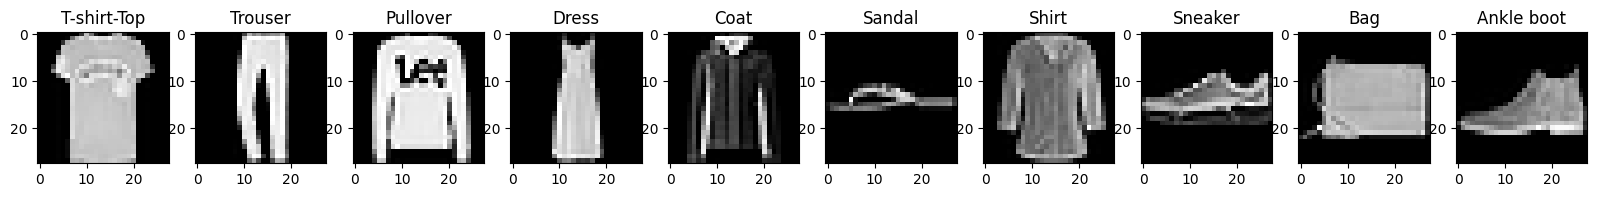

In [ ]:
labeldict = {
    0: 'T-shirt-Top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

items_train = []
items_test = []

for i in range(10):
  items_train.append([])
  items_test.append([])
  for j in range(len(x_train)):
    if y_train[j]==i:
      items_train[i].append(x_train[j])
  for j in range(len(x_test)):
    if y_test[j]==i:
      items_test[i].append(x_test[j])

fig, ax = plt.subplots(1, 10, figsize=(20, 2))

# for i in range(10):
    # ax[i].imshow(x_train[i], cmap='gray')
    # ax[i].set_title(labeldict[y_train[i]])

for i in range(10):
    ax[i].imshow(items_test[i][0], cmap='gray')
    ax[i].set_title(labeldict[i])

In [ ]:


# Klasa która pozwala tworzyć autoenkoder o wybranym poziomie kompresji
class Double_MaxPooling2D_autoencoder:
    def __init__(self, x_train, x_test, y_train, y_test, name, cut_shape):
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test
        self.name = name
        self.cut_shape = cut_shape
        self.input = Input(shape=(28, 28, 1))
        self.model, self.encoder, self.decoder = self.build_model(cut_shape)

    def build_model(self, cut_shape):
        #building encoder
        inputs = self.input
        inputs = Input(shape=(28, 28, 1))

        x = Conv2D(300, (3, 3), activation='relu', padding='same')(inputs)
        x = Conv2D(150, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2))(x)
        x = BatchNormalization()(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2))(x)
        x = BatchNormalization()(x)
        x = Conv2D(64, (2, 2), activation='relu', padding='same')(x)
        x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
        x = Flatten()(x)
        x = Dense(7*7, activation='relu')(x)
        x = BatchNormalization()(x)
        encoded = Dense(cut_shape, activation='relu')(x)

        encoder = Model(inputs=inputs, outputs=encoded)
        encoded_inputs = Input(shape=(cut_shape,))

        x = Dense(cut_shape, activation='relu')(encoded_inputs)
        x = Dense(7*7, activation='relu')(x)
        x = Reshape((7, 7, 1))(x)
        x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
        x = Conv2D(64, (2, 2), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(150, (3, 3), activation='relu', padding='same')(x)
        x = Conv2D(300, (3, 3), activation='relu', padding='same')(x)
        decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

        decoder = Model(inputs=encoded_inputs, outputs=decoded)

        def psnr(y_true, y_pred):
          mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
          psnr = 10 * tf.experimental.numpy.log10(1.0 / tf.math.sqrt(mse))
          return psnr

        x = encoder(inputs)
        x = decoder(x)
        model = Model(inputs=inputs, outputs=x)
        model.compile(optimizer=optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy', 'mse', psnr, 'mae'])

        print(model.summary())

        clr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_delta=0.01,
        cooldown=0,
        min_lr=1e-7,
        verbose=1)

        model.fit(
            x_train,
            x_train,
            batch_size=256,
            epochs=30,
            shuffle=True,
            validation_data=(x_test, x_test),
            callbacks=[clr])

         # Zapisywanie modelu

        folder = os.path.join(folder_base, "Double_MaxPooling2D", str(cut_shape))

        print("Saving autoencoder")
        model_path = os.path.join(folder, "model.h5")
        model.save(model_path)

        print("Saving encoder")
        encoder_path = os.path.join(folder, "encoder.h5")
        encoder.save(encoder_path)

        print("Saving decoder")
        decoder_path = os.path.join(folder, "decoder.h5")
        decoder.save(decoder_path)

        history_path = os.path.join(folder, "history.csv")
        with open(history_path, mode='w') as file:
            writer = csv.writer(file)
            writer.writerow(["Epoch", "Loss", "Accuracy", "MSE", "VAL_MSE", "PSNR", "VAL_PSNR", "MAE", "VAL_MAE"])
            for i, loss in enumerate(model.history.history['loss']):
                epoch = i + 1
                acc = model.history.history['accuracy'][i]
                mse = model.history.history['mse'][i]
                val_mse = model.history.history['val_mse'][i]
                psnr = model.history.history['psnr'][i]
                val_psnr = model.history.history['val_psnr'][i]
                mae = model.history.history['mae'][i]
                val_mae = model.history.history['val_mae'][i]
                writer.writerow([epoch, loss, acc, mse, val_mse, psnr, val_psnr, mae, val_mae])

        return model, encoder, decoder

    def plot_image_reconstructions(self, all_index, items_per_category):
      # Wyświetlanie obrazów i macierzy liczbowych
      fig, axs = plt.subplots(2, 10 * items_per_category, figsize=(30 * items_per_category/2, 6))
      all_encoded = []
      mse_values = []
      psnr_values = []
      # Wyświetlanie obrazu przed enkoderem
      for i in range(10):
          for j in range(items_per_category):
            # Przekształcanie obrazu przez modele enkodera i dekodera
            input_image = items_test[i][all_index[i][0][j]]
            encoded_image = self.encoder.predict(np.expand_dims(input_image, axis=0))
            decoded_image = self.decoder.predict(encoded_image)

            # Pobieranie rozmiarów skompresowanych obrazów
            input_shape = input_image.shape[:2]
            encoded_shape = encoded_image.shape

            fig.suptitle(f'Double MaxPooling2D autoencoder - {self.cut_shape}', fontsize=16)

            # Wyświetlanie obrazu po dekoderze
            axs[0, i * items_per_category + j].imshow(input_image, cmap='gray')
            axs[0, i * items_per_category + j].set_title(labeldict[i])
            axs[0, i * items_per_category + j].axis('off')

            # Wyświetlanie obrazu po dekoderze
            axs[1, i * items_per_category + j].imshow(decoded_image.squeeze(), cmap='gray')
            axs[1, i * items_per_category + j].axis('off')

            all_encoded.append([encoded_image, i, j])
            mse = mean_squared_error(input_image, decoded_image.squeeze())
            psnr = 10 * math.log10(1. / math.sqrt(mse))
            mse_values.append(mse)
            psnr_values.append(psnr)

      plt.tight_layout()
      plt.show()

      folder = os.path.join(folder_base, "Double_MaxPooling2D", str(self.cut_shape), "Encoded")

      print("Encoded output")
      for i in range(len(all_encoded)) :
        print(f"Image {i+1} before decoder:")
        print(f"MSE: {mse_values[i]}")
        print(f"PSNR: {psnr_values[i]}")

        encoded_path = os.path.join(folder, labeldict[all_encoded[i][1]] + str(all_encoded[i][2]) + ".txt")
        os.makedirs(os.path.dirname(encoded_path), exist_ok=True)
        with open(encoded_path, mode='w') as file:
            file.write(str(all_encoded[i][0]))

    def apply_autoencoder(self, dataset):
        encoded_dataset = self.encoder.predict(dataset)
        decoded_dataset = self.decoder.predict(encoded_dataset)
        return decoded_dataset



In [ ]:
# Tworzenie obiektów dla różnych wartości compression_level
double_maxpooling_cut = [49, 36, 25]
double_maxpooling_cut_2 = [16, 9, 4, 2]
autoencoders = []

# Wybieranie losowych indeksów obrazów testowych - po 2 dla każdej klasy
num_samples = 2
all_indexes = []
for i in range(10):
  all_indexes.append([])
  all_indexes[i].append(random.sample(range(len(items_test[i])), num_samples))

for cut in double_maxpooling_cut:
    autoencoder = Double_MaxPooling2D_autoencoder(x_train, x_test, y_train, y_test, f"Double_MaxPooling2D_autoencoder_{cut}", cut)
    autoencoder.plot_image_reconstructions(all_indexes, num_samples)
    autoencoders.append(autoencoder)

for cut in double_maxpooling_cut_2:
    autoencoder = Double_MaxPooling2D_autoencoder(x_train, x_test, y_train, y_test, f"Double_MaxPooling2D_autoencoder_{cut}", cut)
    autoencoder.plot_image_reconstructions(all_indexes, num_samples)
    autoencoders.append(autoencoder)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 model_3 (Functional)        (None, 49)                850357    
                                                                 
 model_4 (Functional)        (None, 28, 28, 1)         816475    
                                                                 
Total params: 1,666,832
Trainable params: 1,665,794
Non-trainable params: 1,038
_________________________________________________________________
None
Epoch 1/30
235/235 [==============================] - 59s 242ms/step - loss: 0.3451 - accuracy: 0.4976 - mse: 0.0341 - psnr: 10.5580 - mae: 0.1094 - val_loss: 1.1417 - val_accuracy: 0.4999 - val_mse: 0.1942 - val_psnr: 6.2024 - val_mae: 0.2838 - lr: 0.0010
Epoch 2/30
235/235 [===========================